In [1]:
import numpy as np
import matplotlib.pyplot as plt
# For Amazon S3 access
import boto3

In [2]:
#!pip install boto3

# Spacecraft and Instrument Details


## Mission

The Defense Meteorology Satellite Program (DMSP) F13 spacecraft is a United States Air Force (USAF) spacecraft whose primary mission is to monitor terrestrial weather to support Deparment of Defense operations and interests. A secondary mission has been to monitior the satellite environment (space weather, SpWx). Because DMSP F13 is an operational military spacecraft where SpWx was a secondary mission, the availability of documentmentation and data products is very different than a spacecraft designed for scientific research. Nonetheless, the sheer longevity of the DMSP spacecraft makes their data worth mining. DMSP F13 provides over 14 years of data (March 1994 to Apr 2009), which covers a full 11-year cycle of wax and wane in solar activity.

## Orbit

DMSP spacecraft are polar-orbiting and [sun-synchronous](https://en.wikipedia.org/wiki/Sun-synchronous_orbit). Below, we read SSJ data from the [AWS Open Data Registry](https://registry.opendata.aws/dmspssj/), and produce a plot of its orbit.


In [3]:
import os

if not os.path.exists('./dat'):
    os.makedirs('./dat')

def download_ssj_from_aws(year,month,day,version,force_download=False):
    """Download SSJ data in netCDF format from https://registry.opendata.aws/dmspssj/"""
    from botocore import UNSIGNED
    from botocore.client import Config
    #This Config enables us to anonymously access a public S3 bucket
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED),region_name='us-west-2')
    bucket_name = 'dmspssj'
    bucket_path = f'data/raw/netcdf/year={year}/month={month}/'
    fn = f'dmsp-f13_ssj_precipitating-electrons-ions_{year:02d}{month:02d}{day:02}_v{version}.nc'
    object_name = bucket_path+fn
    file_name = os.path.join('./dat',fn)
    if not os.path.exists(file_name) or force_download:
        s3.download_file(bucket_name, object_name, file_name)
    return file_name

netcdf_fn1 = download_ssj_from_aws(2003,10,29,'1.1.5')
netcdf_fn2 = download_ssj_from_aws(2003,10,30,'1.1.5')


In [4]:
from ssjlatbin.netcdf import ReadOnlyConvertedNC
import xarray as xr

ds1 = xr.load_dataset(netcdf_fn1)
ds2 = xr.load_dataset(netcdf_fn2)

for ds in [ds1,ds2]:
    #Convert the time format from milliseconds since 0AD to hours since start of day
    secs_since_0AD = ds['Epoch'].values/1000.
    hours_since_midnight = np.mod(secs_since_0AD,86400)/3600.
    ds['hour_of_day']=hours_since_midnight

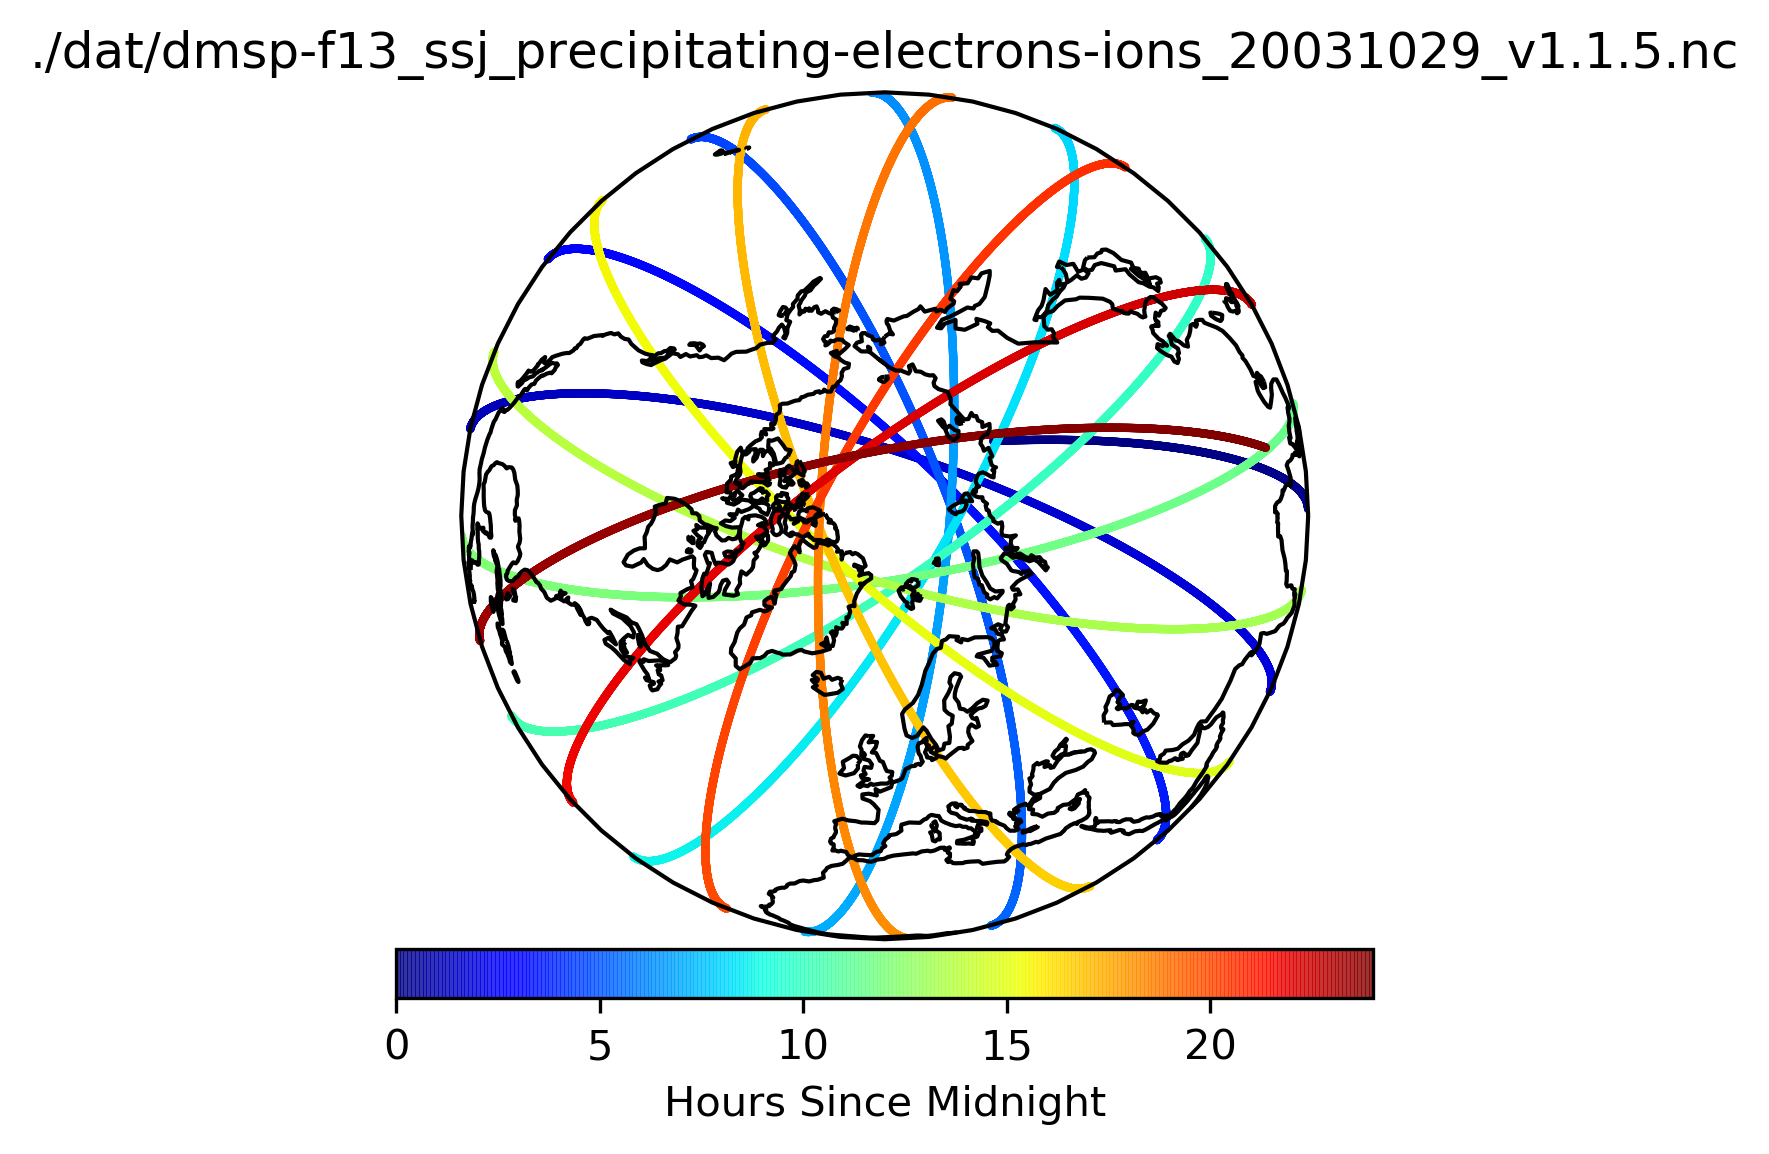

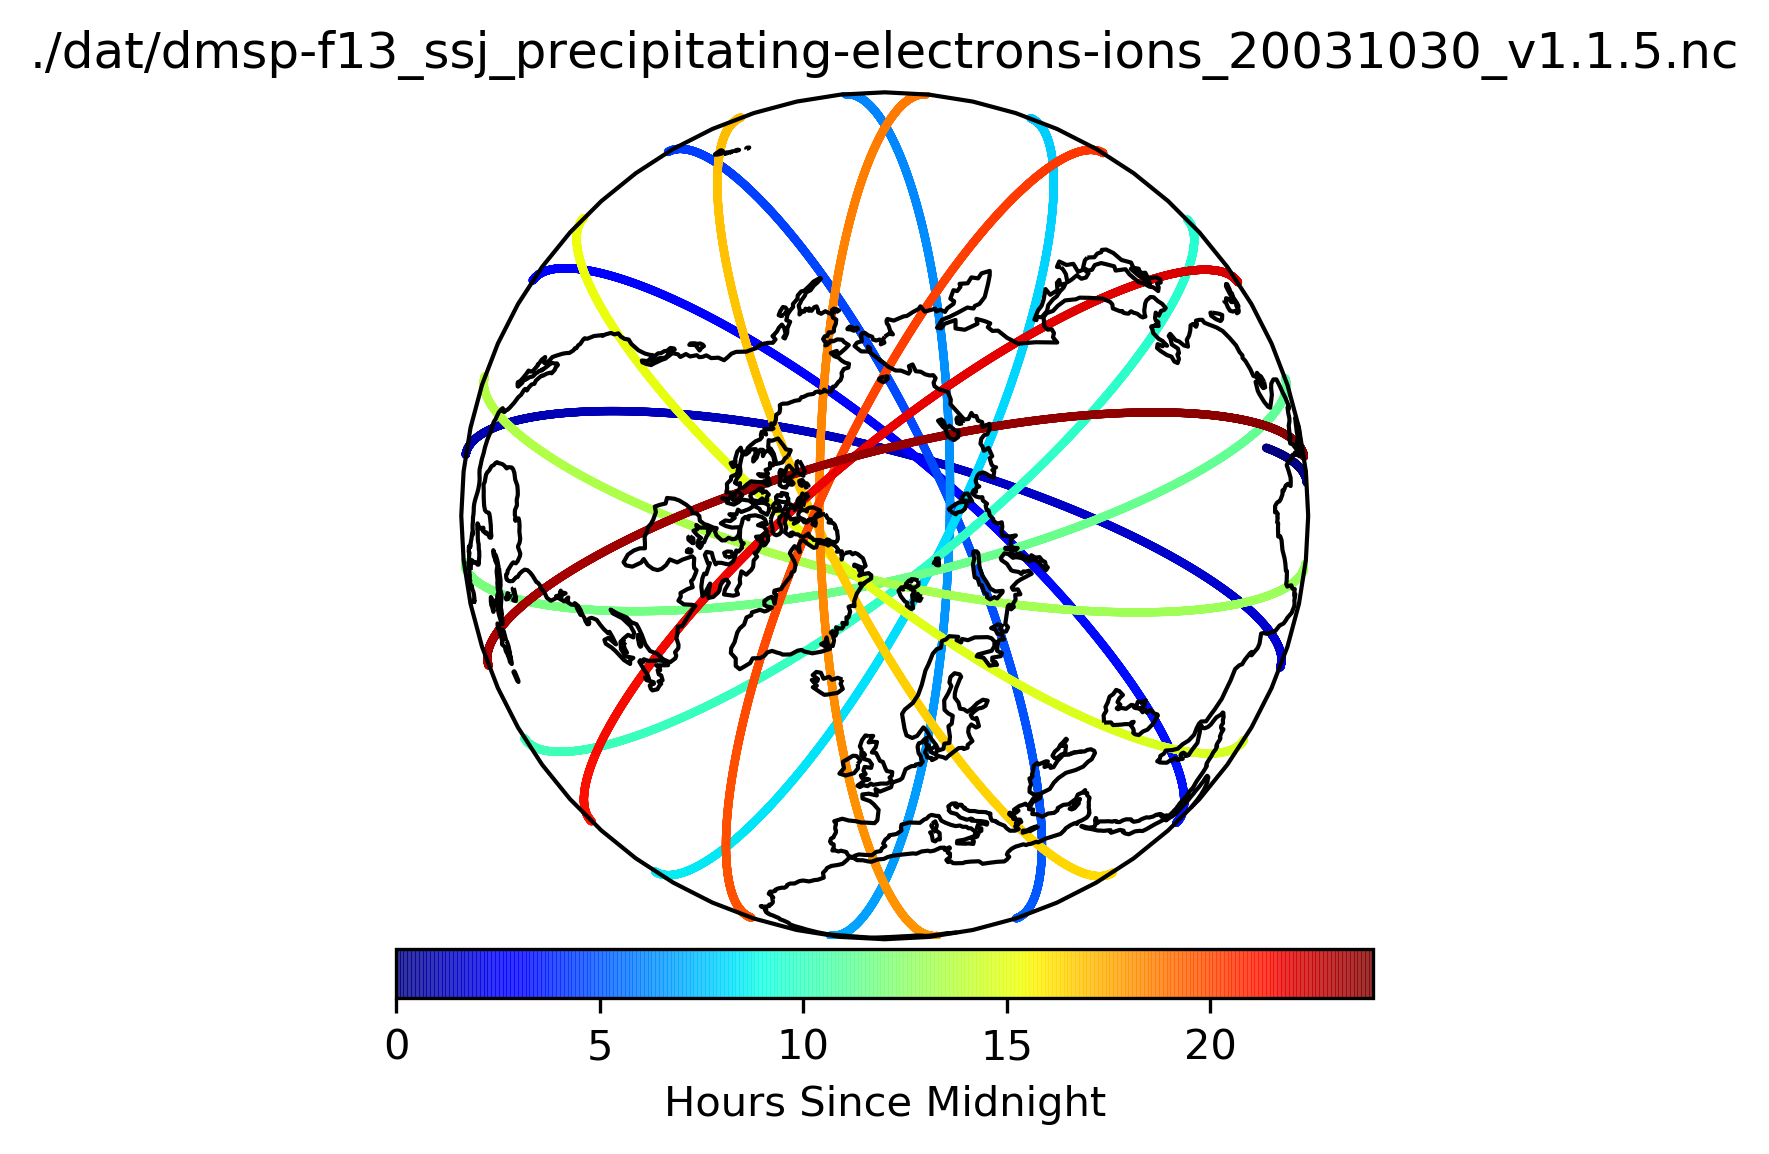

In [5]:
import pandas as pd
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm
import datetime

projection_map = ccrs.Orthographic(0, 90)
transform = ccrs.PlateCarree()

for ds,ncfn in [(ds1,netcdf_fn1),(ds2,netcdf_fn2)]:
    fmap = plt.figure(figsize=(6,4),dpi=300)
    axmap = fmap.add_subplot(111,projection=projection_map)
    axmap.coastlines()
    mappable = axmap.scatter(ds['SC_GEOCENTRIC_LON'],ds['SC_GEOCENTRIC_LAT'],1,ds['hour_of_day'],cmap='jet',transform=transform,alpha=.8)
    axmap.set_title('{}'.format(ncfn))
    fmap.colorbar(mappable,ax=axmap,orientation='horizontal',label='Hours Since Midnight',shrink=.7,pad=.01)
    fmap.tight_layout()

# Software

### Purpose

The [ssj_latbin](https://doi.org/10.5281/zenodo.5768487) Python package was made for this project and does the following:

* Reading the raw SSJ data (in-situ particle flux at 1 Hz cadence) into a [Pandas Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html)
* Organizing the data into [zonal](https://en.wikipedia.org/wiki/Zonal_and_meridional_flow) averages

### Configuration settings.

The most important configuration settings are:
* `delta_lat` - the width of the bins (in degrees) into which each orbit is divided
* `uncertainty_tolerance` has to do with filtering out observations which have large uncertainty in flux. Specifically, the code requires $\Phi > \frac{tol}{100}*\sigma_{\Phi}$ where $\Phi$ is flux, $tol$ is `uncertainty_tolerance` and $\sigma_{\Phi}$ is the flux uncertainty.
* `ssj_nc_root_dir` - the path to the data (using netCDF format)
* `ssj_nc_version` - the SSJ data version (using netCDF format)

In [6]:
from ssjlatbin.io import read_config
config = read_config('../scripts/default_config.toml')

dmsp_number = 13
sdt = datetime.datetime(2003,10,28)
edt = datetime.datetime(2003,11,1)
sdtstr = sdt.strftime('%Y%m%d')
edtstr = edt.strftime('%Y%m%d')

dt = sdt
while dt < edt:
    ncfn = download_ssj_from_aws(dt.year,dt.month,dt.day,'1.1.5',force_download=False)
    print(f'Downloaded {ncfn}')
    dt+=datetime.timedelta(days=1)

config['latbin']['delta_lat']=3
config['io']['cdf_or_nc']='nc'
config['io']['ssj_nc_root_dir']='./dat' #Change path to be appropriate
config['calculation']['uncertainty_tolerance']=100
config['io']['ssj_nc_version']='1.1.5'

Downloaded ./dat/dmsp-f13_ssj_precipitating-electrons-ions_20031028_v1.1.5.nc
Downloaded ./dat/dmsp-f13_ssj_precipitating-electrons-ions_20031029_v1.1.5.nc
Downloaded ./dat/dmsp-f13_ssj_precipitating-electrons-ions_20031030_v1.1.5.nc
Downloaded ./dat/dmsp-f13_ssj_precipitating-electrons-ions_20031031_v1.1.5.nc


# Particle Flux Calculations

### DMSP SSJ Channels

This guide is a high-level overview of this data, specifically considering how it used to create a Machine-Learning-Ready latitude binned data product. For in-depth details on SSJ data, see [Redmon et al., 2017](https://doi.org/10.1002/2016JA023339)

The detector measures the flux (number of particles per area per time), of ions and electrons incident on the spacecraft from above (hence particle *precipitation* as we imagine the particles falling like rain).

There are seperate detectors for electrons and ions. Both of these detectors have 19 channels (technically 20, including a redundant pair, but we only consider the 19 unique channels). Each channel is sensitive only to particles with kinetic energies in a certain range. This table shows the energy to which each channel is most sensitive (the center energy), in units of electron-volts (1 eV = 1.6*10$^{-19}$ J).

<table style="border:1px solid black"><tbody><tr style="border:1px solid black"><th style="border:1px solid black">0</th><th style="border:1px solid black">1</th><th style="border:1px solid black">2</th><th style="border:1px solid black">3</th><th style="border:1px solid black">4</th><th style="border:1px solid black">5</th><th style="border:1px solid black">6</th><th style="border:1px solid black">7</th><th style="border:1px solid black">8</th><th style="border:1px solid black">9</th><th style="border:1px solid black">10</th><th style="border:1px solid black">11</th><th style="border:1px solid black">12</th><th style="border:1px solid black">13</th><th style="border:1px solid black">14</th><th style="border:1px solid black">15</th><th style="border:1px solid black">16</th><th style="border:1px solid black">17</th><th style="border:1px solid black">18</th></tr><tr style="border:1px solid black"><td style="border:1px solid black">30180 eV</td><td style="border:1px solid black">20620 eV</td><td style="border:1px solid black">14040 eV</td><td style="border:1px solid black">9580 eV</td><td style="border:1px solid black">6500 eV</td><td style="border:1px solid black">4420 eV</td><td style="border:1px solid black">3050 eV</td><td style="border:1px solid black">2060 eV</td><td style="border:1px solid black">1410 eV</td><td style="border:1px solid black">992 eV</td><td style="border:1px solid black">679 eV</td><td style="border:1px solid black">462 eV</td><td style="border:1px solid black">317 eV</td><td style="border:1px solid black">213 eV</td><td style="border:1px solid black">145 eV</td><td style="border:1px solid black">100 eV</td><td style="border:1px solid black">68 eV</td><td style="border:1px solid black">46 eV</td><td style="border:1px solid black">32 eV</td></tr></tbody></table>

Particles of different kinetic energies interact with the ionosphere in different ways, and are energized and precipiated by different magnetosphere-ionosphere mechanisms. We divide the particles measured by SSJ into two broad categories: hard, for higher energies, and soft, for lower energies. The cutoff is around 1 keV, but specifically we define:

* soft_channels = [10,11,12,13,14,15,16,17]
* hard_channels = [0,1,2,3,4,5,6,7,8]

> ⚠️ Within the `ssj_latbin` package, the `fluxcalculations` module handles these calculations

### Types of Flux

Following [Hardy et al. 2008](https://doi.org/10.1029/2007JA012746), specifically equations 2 and 3, we calculate two varieties of particle flux: 

* **Number flux** $\Phi_{N}$ with units $\frac{particles}{m^2 s}$ ⚠️ *Note that we use $\frac{1}{m^2}$ where Hardy uses $\frac{1}{cm^2}$*
* **Energy flux** $\Phi_{E}$ with units $\frac{ergs}{cm^2 s}$, or equivalently $\frac{mW}{m^2}$

Like Hardy, our calculations total the flux across all channels, but we additionally calculate using the soft and hard channel sets above. The result is total, hard and soft number and energy fluxes for ions and electrons (a total of 12 flux parameters).



# Visualizing Fluxes

The `get_orbit_numbered_ssj_range_dataframe` method loads the *raw* particle precipitation observations (1 observation per second) into a Pandas dataframe.

Below, we plot the hard electron energy flux and soft ion number flux for the first part of one day.

In [7]:
from ssjlatbin.cdf import get_orbit_numbered_ssj_range_dataframe
#Subselect for groundtrack plots
df0 = get_orbit_numbered_ssj_range_dataframe(dmsp_number,sdt,edt,config)
df=df0.loc['2003-10-30T00:00':'2003-10-30T11:00']

File not found for date 2003-10-27 00:00:00


/home/liamk/Projects/ssj_latbin/ssjlatbin/fluxcalculations.py:100: RuntimeWarning: invalid value encountered in true_divide
  too_uncert = integral_flux_std/integral_flux*100>=uncertainty_tolerance


Read ./dat/dmsp-f13_ssj_precipitating-electrons-ions_20031028_v1.1.5.nc took 2.958997 seconds
Read ./dat/dmsp-f13_ssj_precipitating-electrons-ions_20031029_v1.1.5.nc took 2.958763 seconds
Read ./dat/dmsp-f13_ssj_precipitating-electrons-ions_20031030_v1.1.5.nc took 3.013177 seconds
Read ./dat/dmsp-f13_ssj_precipitating-electrons-ions_20031031_v1.1.5.nc took 3.067888 seconds


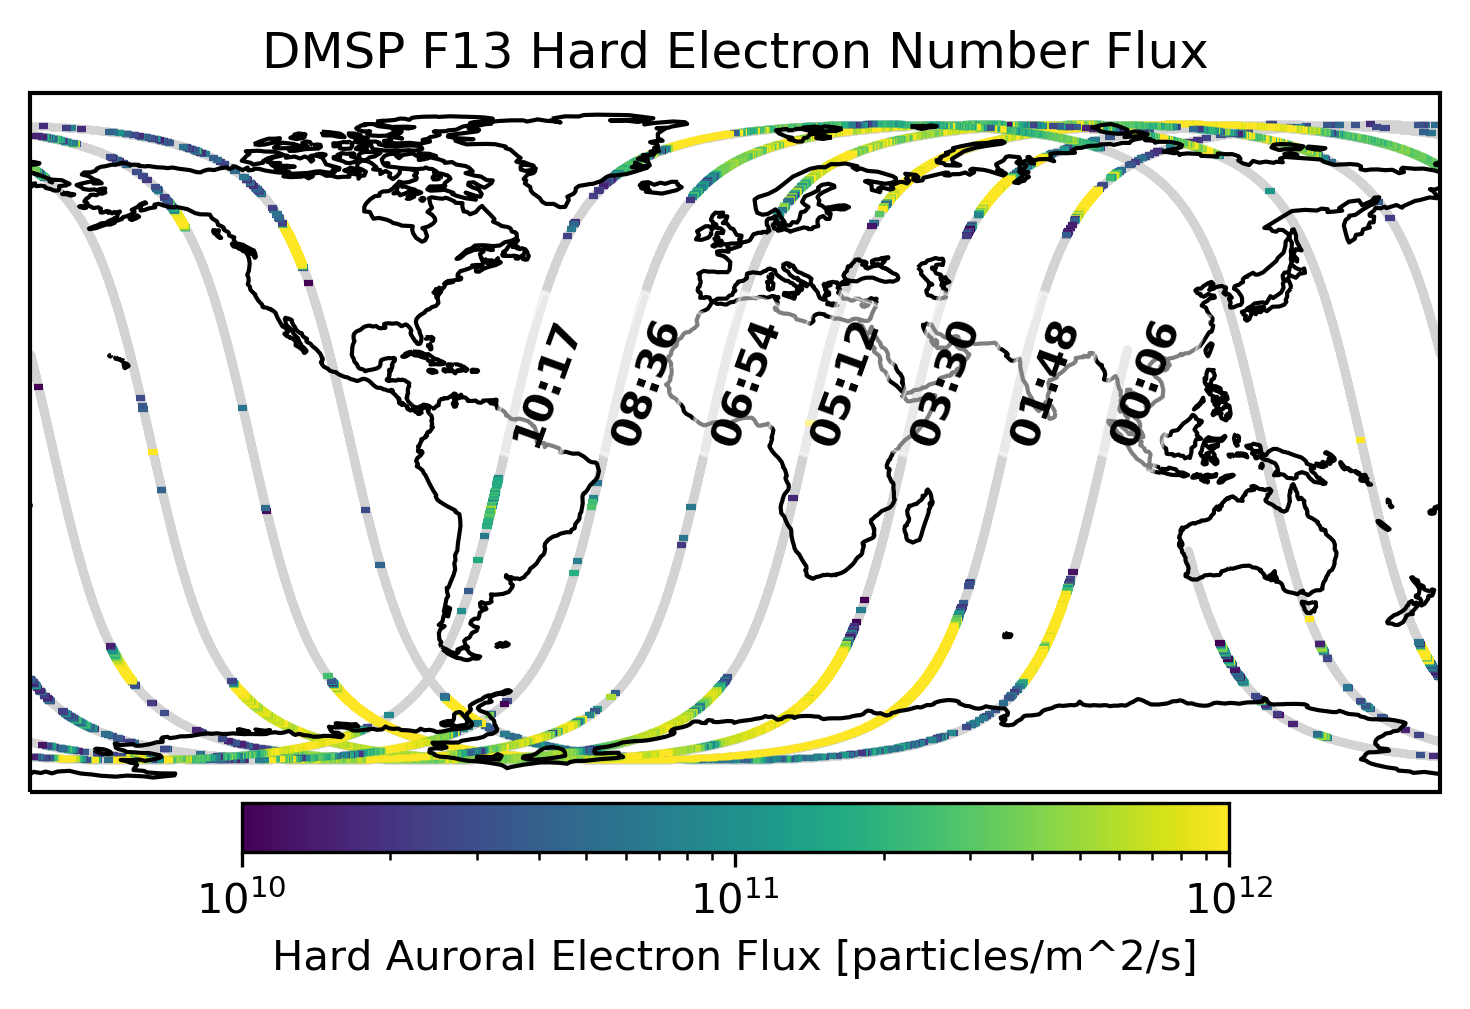

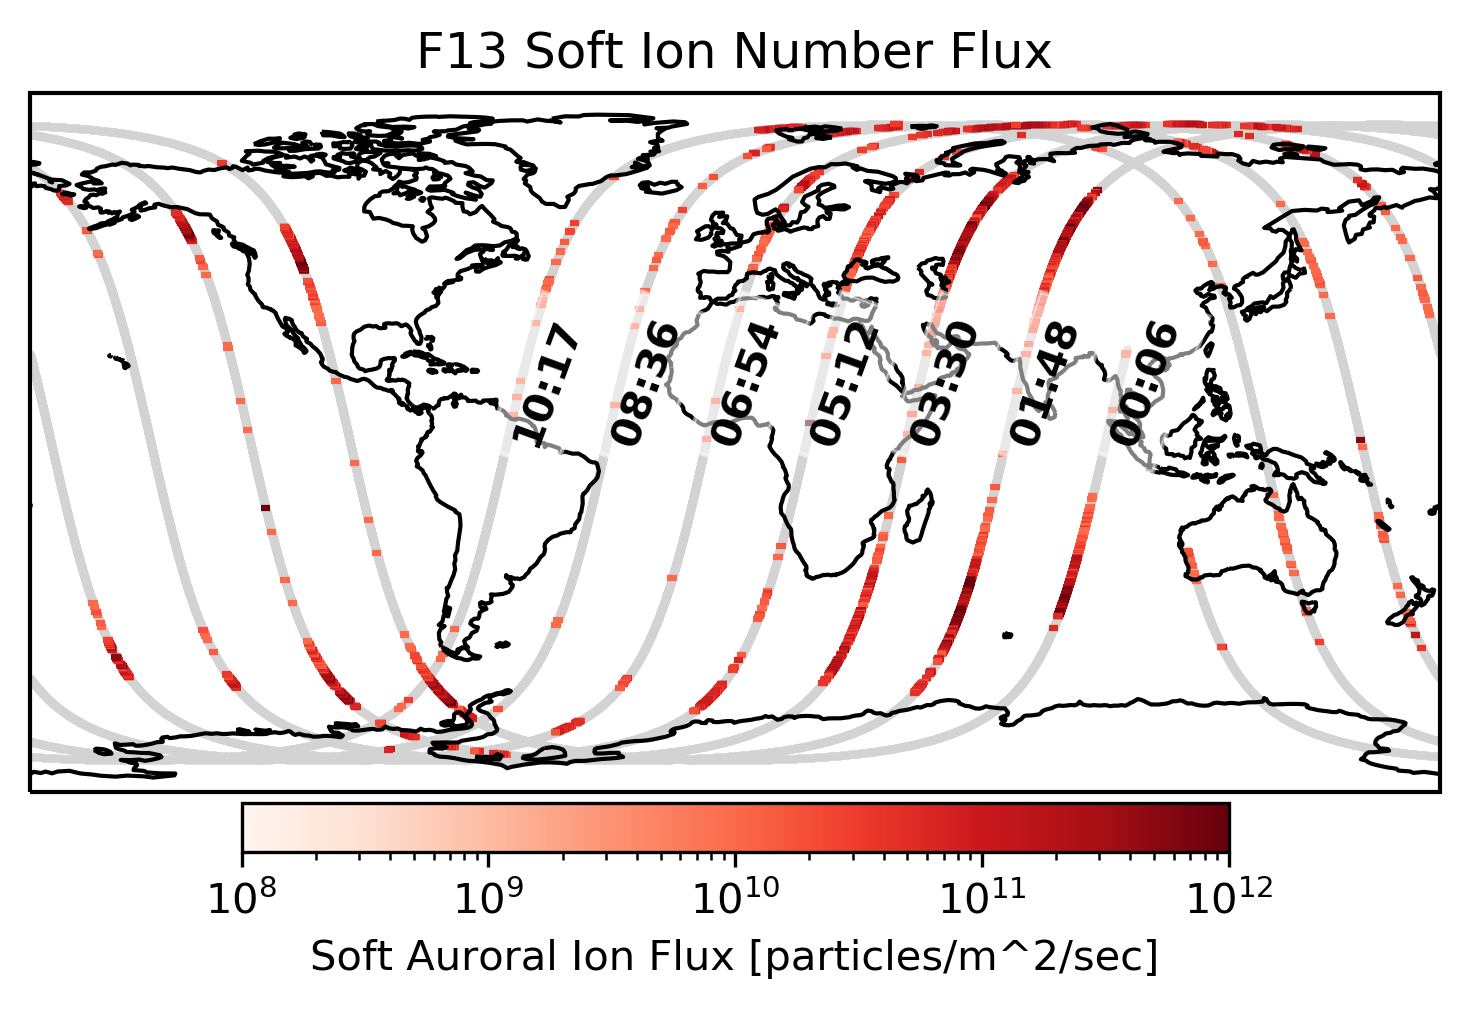

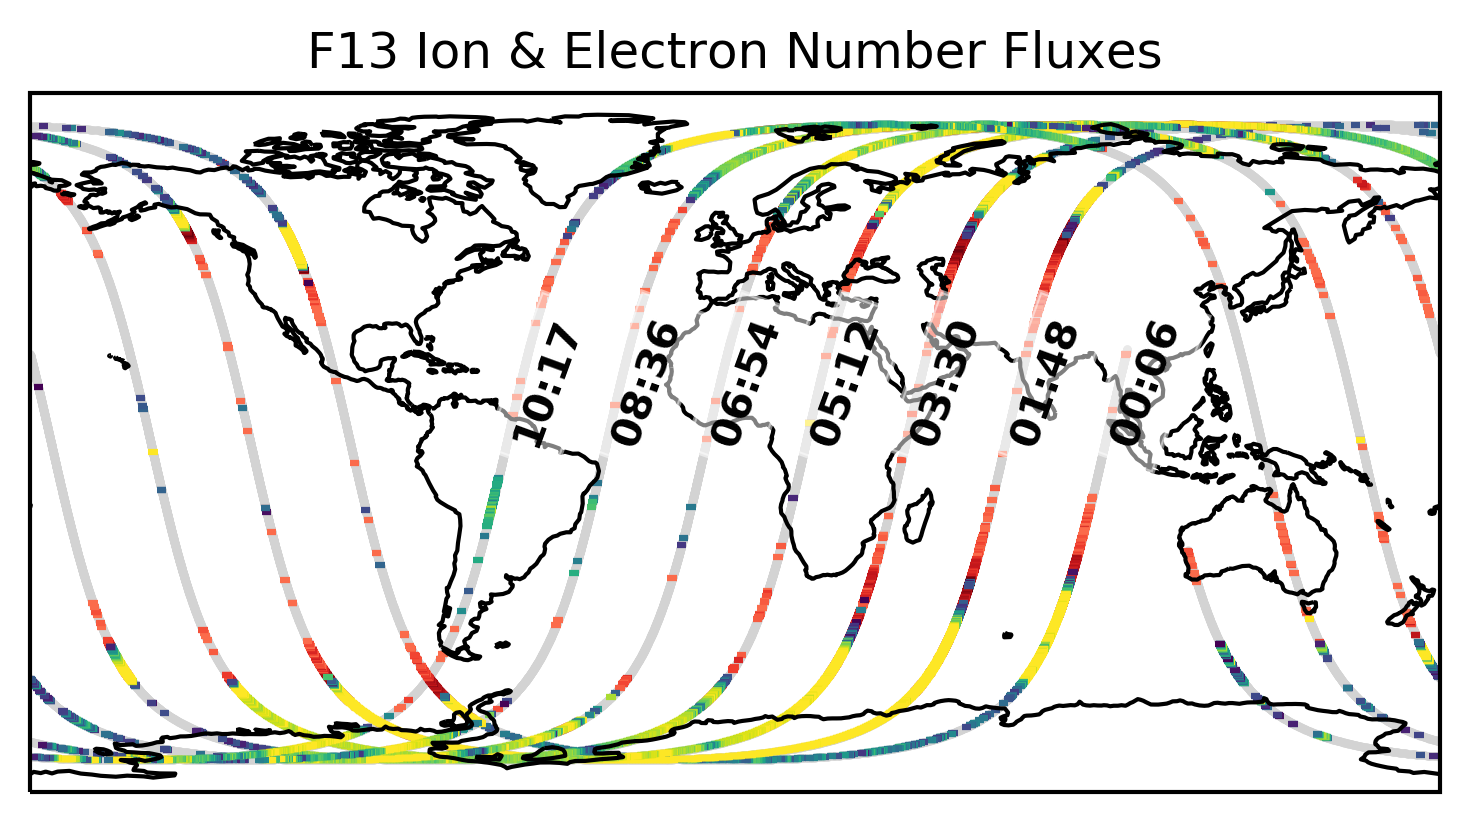

In [8]:
from matplotlib.colors import LogNorm
import datetime

projection_map = ccrs.PlateCarree()
transform = ccrs.PlateCarree()

def label_orbit_start_time(ax,df,**kwargs):
    orbit_start_df = df.groupby('orbit_number').first()
    for iorbit in range(1,len(orbit_start_df.index)):
        dt=orbit_start_df['time'].iloc[iorbit].to_pydatetime()
        t=ax.text(orbit_start_df['glons'].iloc[iorbit],orbit_start_df['glats'].iloc[iorbit],dt.strftime('%H:%M'),
                   fontsize=10,rotation=70,color='black',fontweight='bold',**kwargs)
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

fmap = plt.figure(figsize=(5,4),dpi=300)
axmap = fmap.add_subplot(111,projection=projection_map)
axmap.coastlines()
axmap.scatter(df['glons'],df['glats'],1,'lightgrey',transform=transform,alpha=.8)
label_orbit_start_time(axmap,df,transform=transform) 
mappablemap=axmap.scatter(df['glons'],df['glats'],5,df['ele_hard_number'],cmap='viridis',marker='_',vmin=1e10,vmax=1e12,norm=LogNorm(),transform=transform)
axmap.set_title('DMSP F13 Hard Electron Number Flux')
fmap.colorbar(mappablemap,ax=axmap,orientation='horizontal',label='Hard Auroral Electron Flux [particles/m^2/s]',shrink=.7,pad=.01)
fmap.tight_layout()
fmap.savefig(f'hard_electron_map_{sdtstr}_{edtstr}.png')

fmapi = plt.figure(figsize=(5,4),dpi=300)
axmapi = fmapi.add_subplot(111,projection=projection_map)
axmapi.coastlines()
axmapi.scatter(df['glons'],df['glats'],1,'lightgrey',transform=transform,alpha=.8)
label_orbit_start_time(axmapi,df,transform=transform)
mappablemapi=axmapi.scatter(df['glons'],df['glats'],5,df['ion_soft_number'],cmap='Reds',marker='_',vmin=1e8,vmax=1e12,norm=LogNorm(),transform=transform)
fmapi.colorbar(mappablemapi,ax=axmapi,orientation='horizontal',label='Soft Auroral Ion Flux [particles/m^2/sec]',shrink=.7,pad=.01)
fmapi.tight_layout()
axmapi.set_title('F13 Soft Ion Number Flux')
fmapi.savefig(f'soft_ion_map_{sdtstr}_{edtstr}.png')

fmapie = plt.figure(figsize=(5,4),dpi=300)
axmapie = fmapie.add_subplot(111,projection=projection_map)
axmapie.coastlines()
axmapie.scatter(df['glons'],df['glats'],1,'lightgrey',transform=transform,alpha=.8)
label_orbit_start_time(axmapie,df,transform=transform)
axmapie.scatter(df['glons'],df['glats'],5,df['ion_soft_number'],cmap='Reds',marker='_',vmin=1e8,vmax=1e12,norm=LogNorm(),transform=transform)
axmapie.scatter(df['glons'],df['glats'],5,df['ele_hard_number'],cmap='viridis',marker='_',vmin=1e10,vmax=1e12,norm=LogNorm(),transform=transform)
axmapie.set_title('F13 Ion & Electron Number Fluxes')

fmapie.tight_layout()
fmapie.savefig(f'ion_electron_map_{sdtstr}_{edtstr}.png')

# Binning by Latitude

The below code bins the orbits above into latitude bins. 

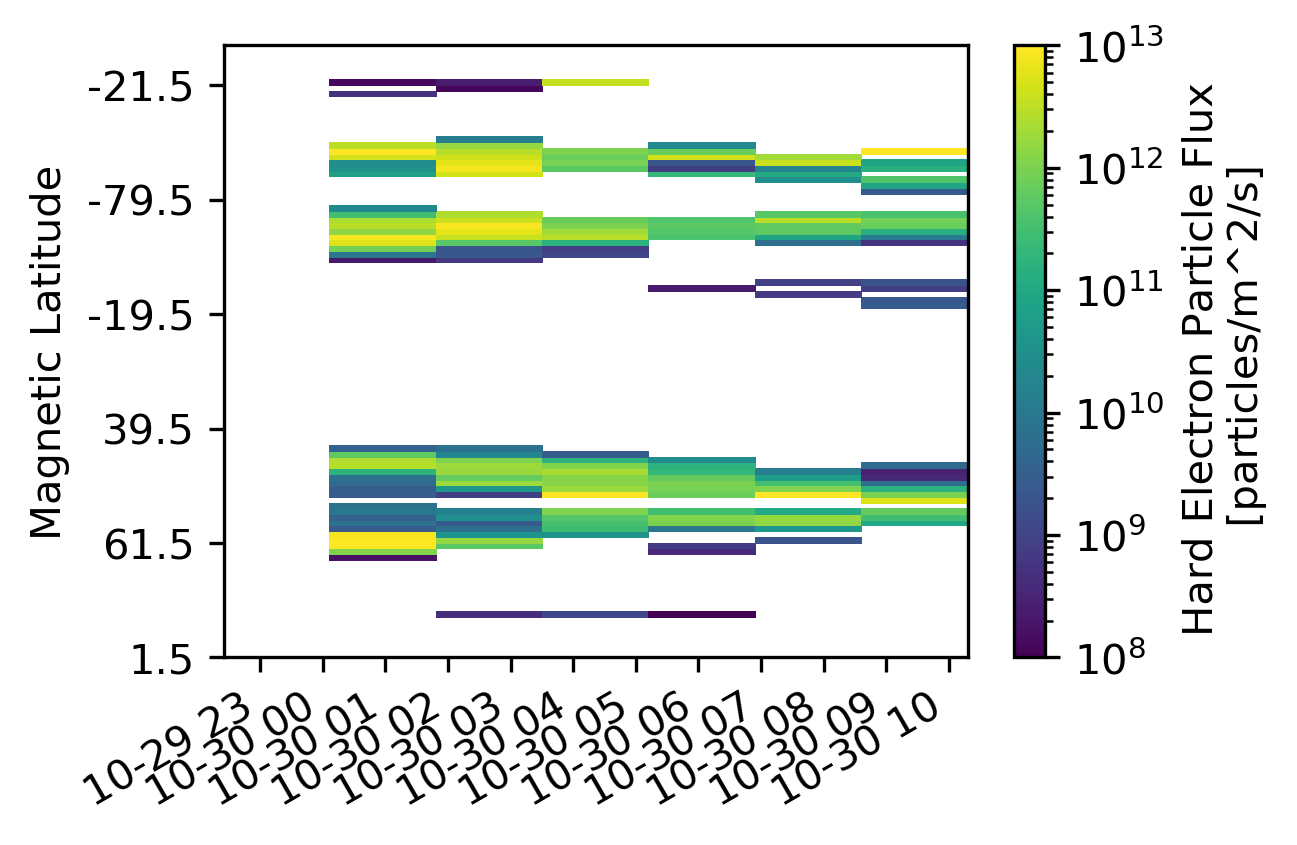

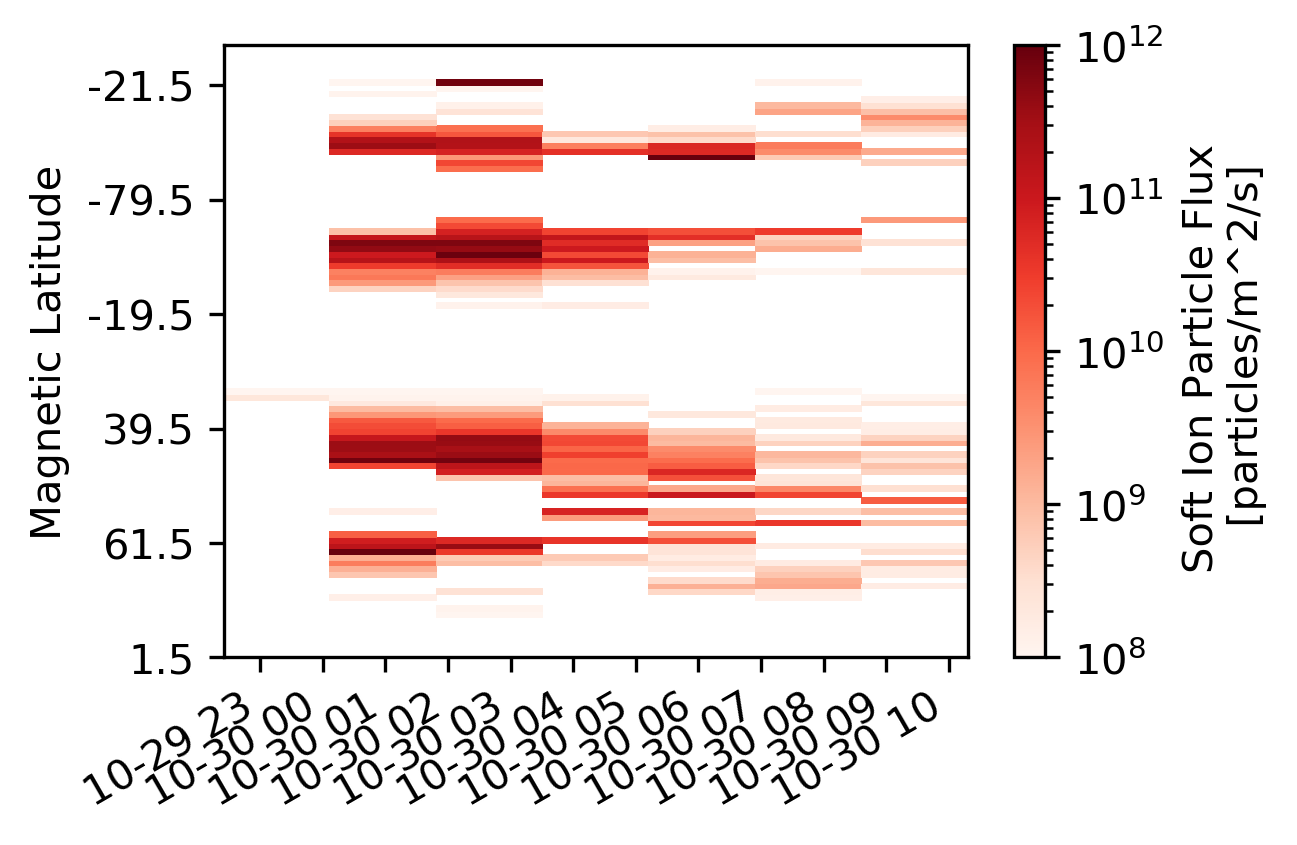

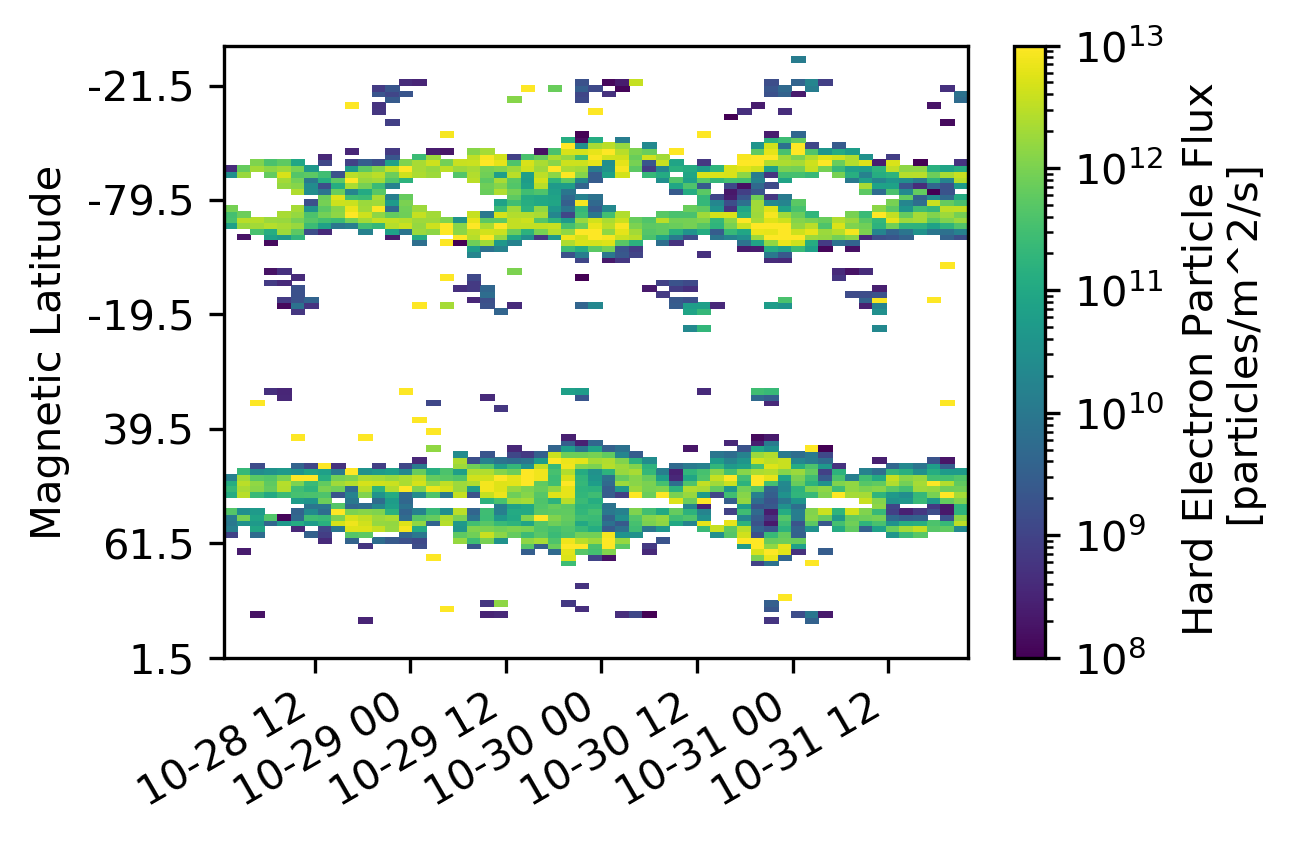

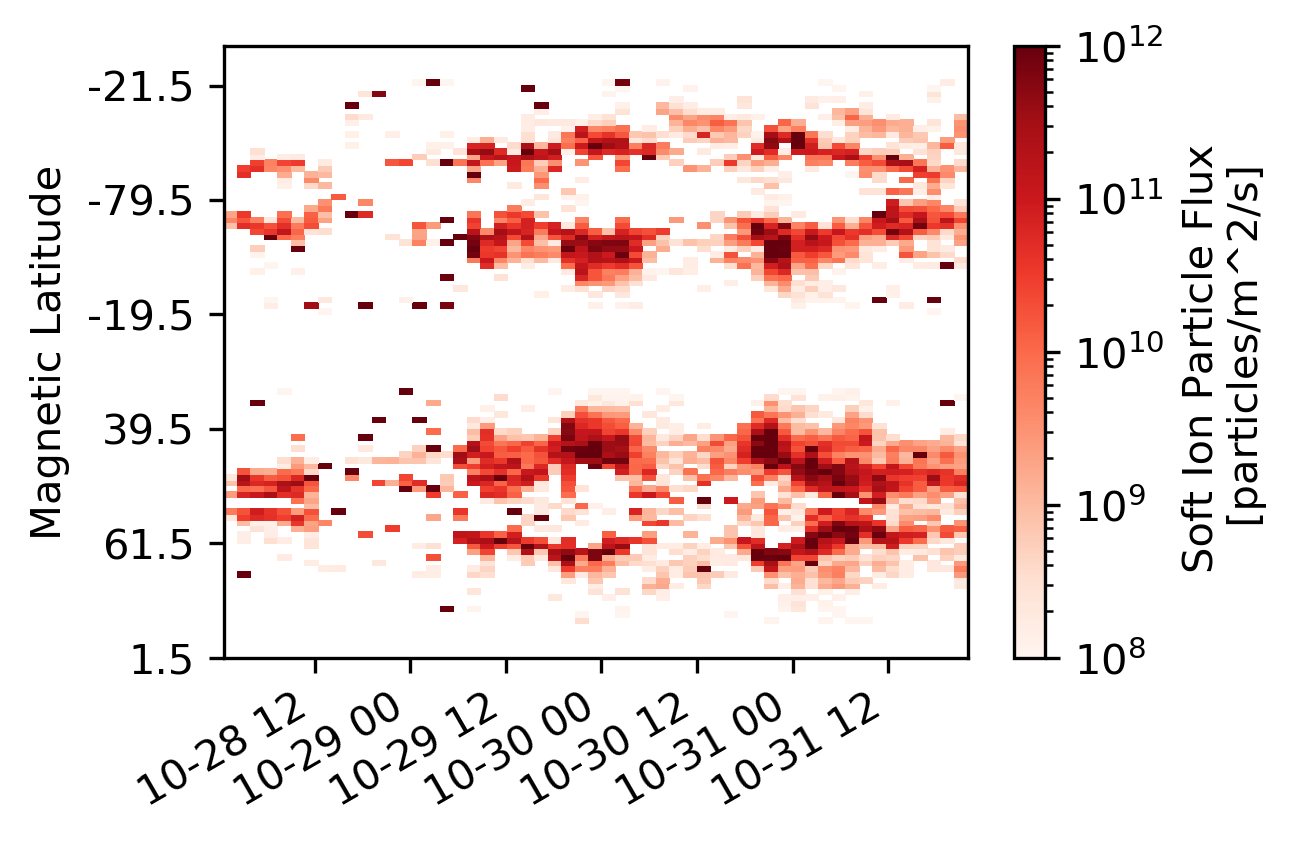

In [9]:
from ssjlatbin.latbin_pandas import bin_by_latitude
from ssjlatbin.io import dataframe_to_latbinned_flux


for thisdf in [df,df0]:
    
    lbdf = bin_by_latitude(thisdf,config,latvar='mlats')

    t,lats,_,influxs = dataframe_to_latbinned_flux(lbdf,'ion_soft_number')
    t,lats,_,enfluxh = dataframe_to_latbinned_flux(lbdf,'ele_hard_number')

    def latlabel(value,tick_number):
        ilat = int(np.round(value))
        if ilat>=len(lats):
            ilat=len(lats)-1
        return '{}'.format(lats[ilat])

    f3 = plt.figure(figsize=(4,3),dpi=300)
    ax3 = f3.add_subplot(111)
    mappable = ax3.pcolormesh(t,np.arange(lats.size),enfluxh.T,vmin=1e8,vmax=1e13,cmap='viridis',norm=LogNorm())
    ax3.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
    ax3.set_ylabel('Magnetic Latitude')
    f3.colorbar(mappable,label='Hard Electron Particle Flux \n [particles/m^2/s]')
    f3.autofmt_xdate()

    f4 = plt.figure(figsize=(4,3),dpi=300)
    ax4 = f4.add_subplot(111)
    mappable = ax4.pcolormesh(t,np.arange(lats.size),influxs.T,vmin=1e8,vmax=1e12,cmap='Reds',norm=LogNorm())
    ax4.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
    ax4.set_ylabel('Magnetic Latitude')
    f4.colorbar(mappable,label='Soft Ion Particle Flux \n [particles/m^2/s]')
    f4.autofmt_xdate()



# Median Filter (Convolution)

Note that the plots above have some 'speckling', i.e. isolated single bin signals. The signals may be real precipitating particles or they may be 'contamination' from either very high energy particles or other spacecraft signals. If we want to use this data to train ML algorithms to detect unusual signals in the more coherent patters, we have to remove the speckling, otherwise the algorithm will react to it. We accomplish this using a 3x3 median filter, meaning the value assigned to each latitude bin is the median of 8 bins surrounding it (3 from the previous orbit, the bin above and below it, and 3 from the orbit after).

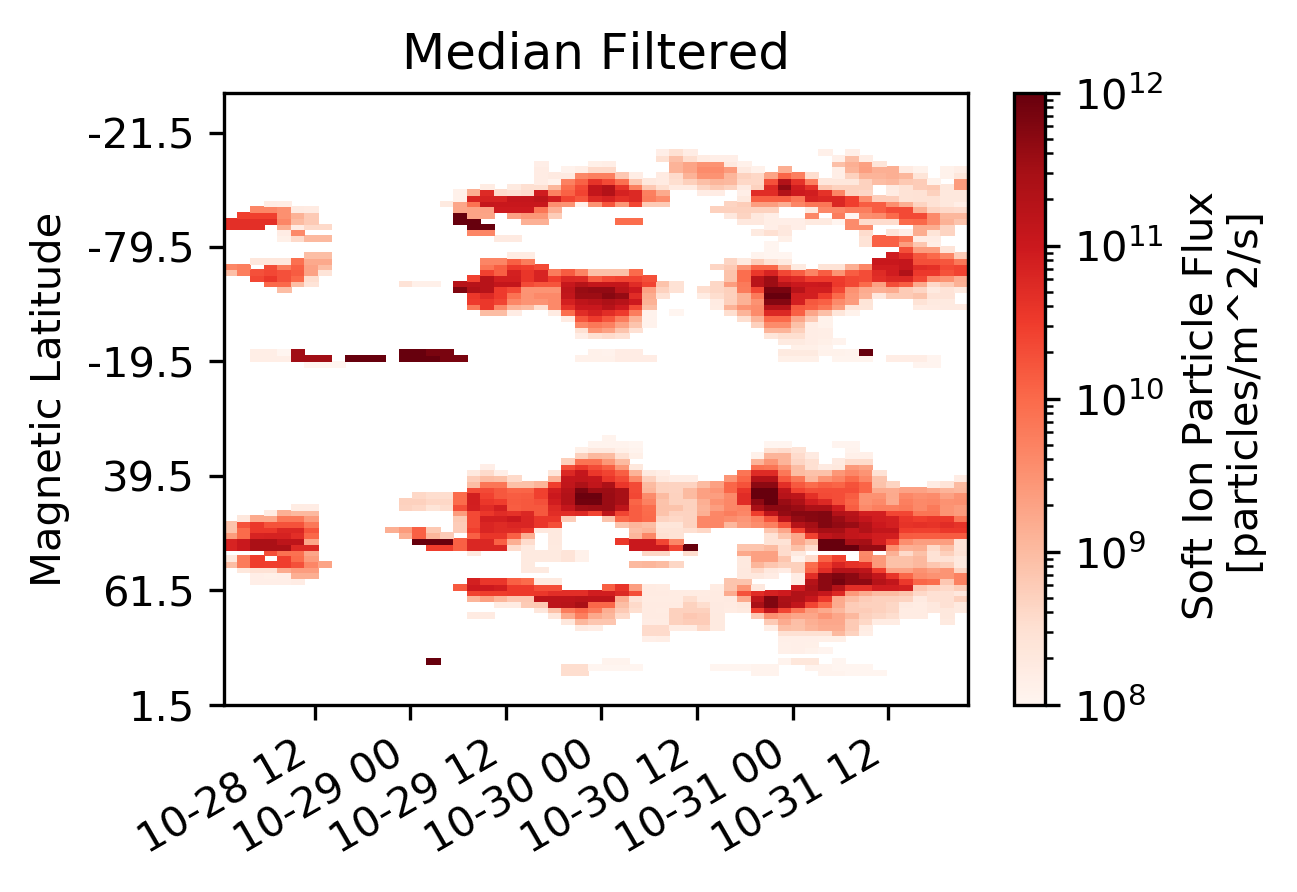

In [12]:
from scipy.ndimage import median_filter
ksize=(3,3)

lbdf = bin_by_latitude(df0,config,latvar='mlats')
t,lats,_,influxs = dataframe_to_latbinned_flux(lbdf,'ion_soft_number')

f3 = plt.figure(figsize=(4,3),dpi=300)
ax3 = f3.add_subplot(111)
mappable = ax3.pcolormesh(t,np.arange(lats.size),median_filter(influxs.T,ksize),vmin=1e8,vmax=1e12,cmap='Reds',norm=LogNorm())
ax3.yaxis.set_major_formatter(plt.FuncFormatter(latlabel))
ax3.set_ylabel('Magnetic Latitude')
f3.colorbar(mappable,label='Soft Ion Particle Flux \n [particles/m^2/s]')
ax3.set_title('Median Filtered')
f3.autofmt_xdate()

# Putting it all together

This figure shows a view of several parameters for only one hemisphere (northern) and one localtime sector (the dawnside). 

One new parameter is shown, the electron average energy, which is the ratio of the electron energy flux and the electron number flux, or losely, the most common energy of electron precipitating for that bin. This parameter is known to be lower during strong geomagnetic storms.

The figure at the bottom shows the solar wind conditions.

/home/liamk/Projects/ssj_latbin/ssjlatbin/fluxcalculations.py:113: RuntimeWarning: divide by zero encountered in true_divide
  eavg = (integrated_energy_flux/1.6e-19/1000)/integrated_number_flux #mW/m^2->eV/m^2
/home/liamk/Projects/ssj_latbin/ssjlatbin/fluxcalculations.py:113: RuntimeWarning: invalid value encountered in true_divide
  eavg = (integrated_energy_flux/1.6e-19/1000)/integrated_number_flux #mW/m^2->eV/m^2
/home/liamk/anaconda3/lib/python3.7/site-packages/spacepy/pycdf/__init__.py:3695: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.degen = numpy.zeros(self.dims, dtype=numpy.bool)
/home/liamk/anaconda3/lib/python3.7/site-packages/spacepy/pycdf/__init__

Created interval between 2003-10-28 and 2003-11-01, cadence 5min, start index 7776, end index 0
Created interval between 2003-10-28 and 2003-11-01, cadence hourly, start index 2856, end index 2952
Applying transform Hourly Kp*10 -> Kp to omni hourly variable KP


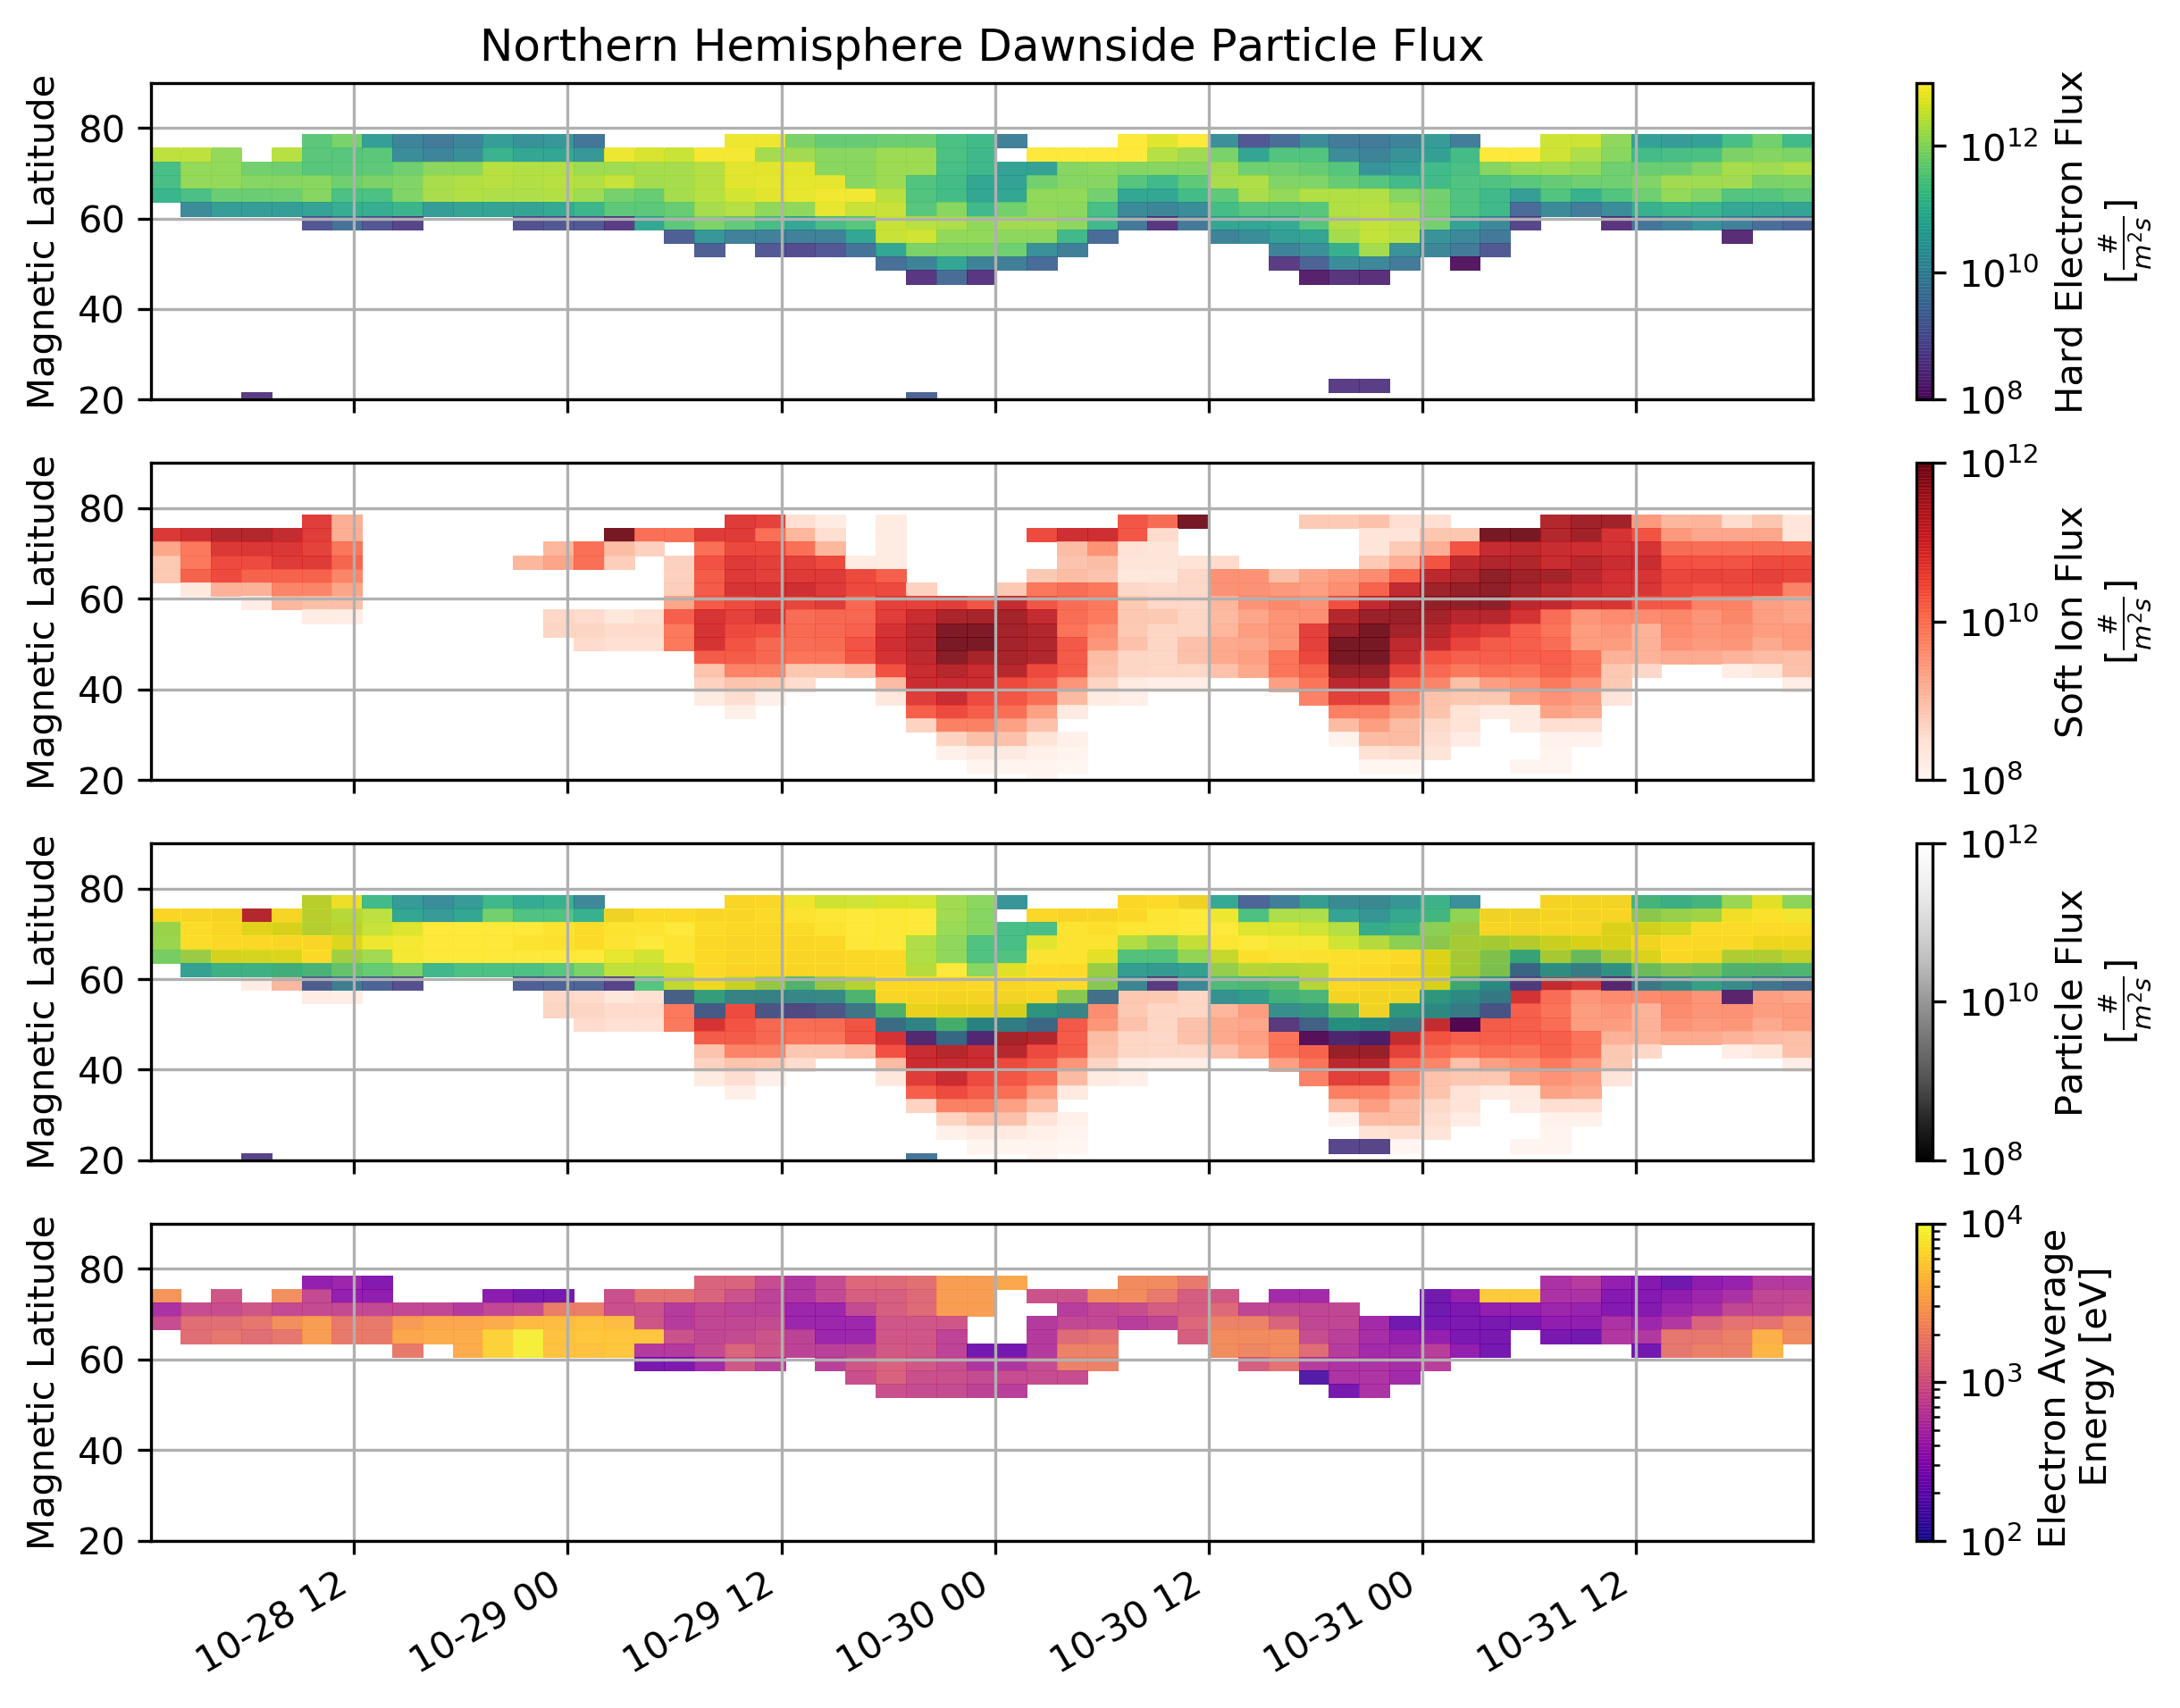

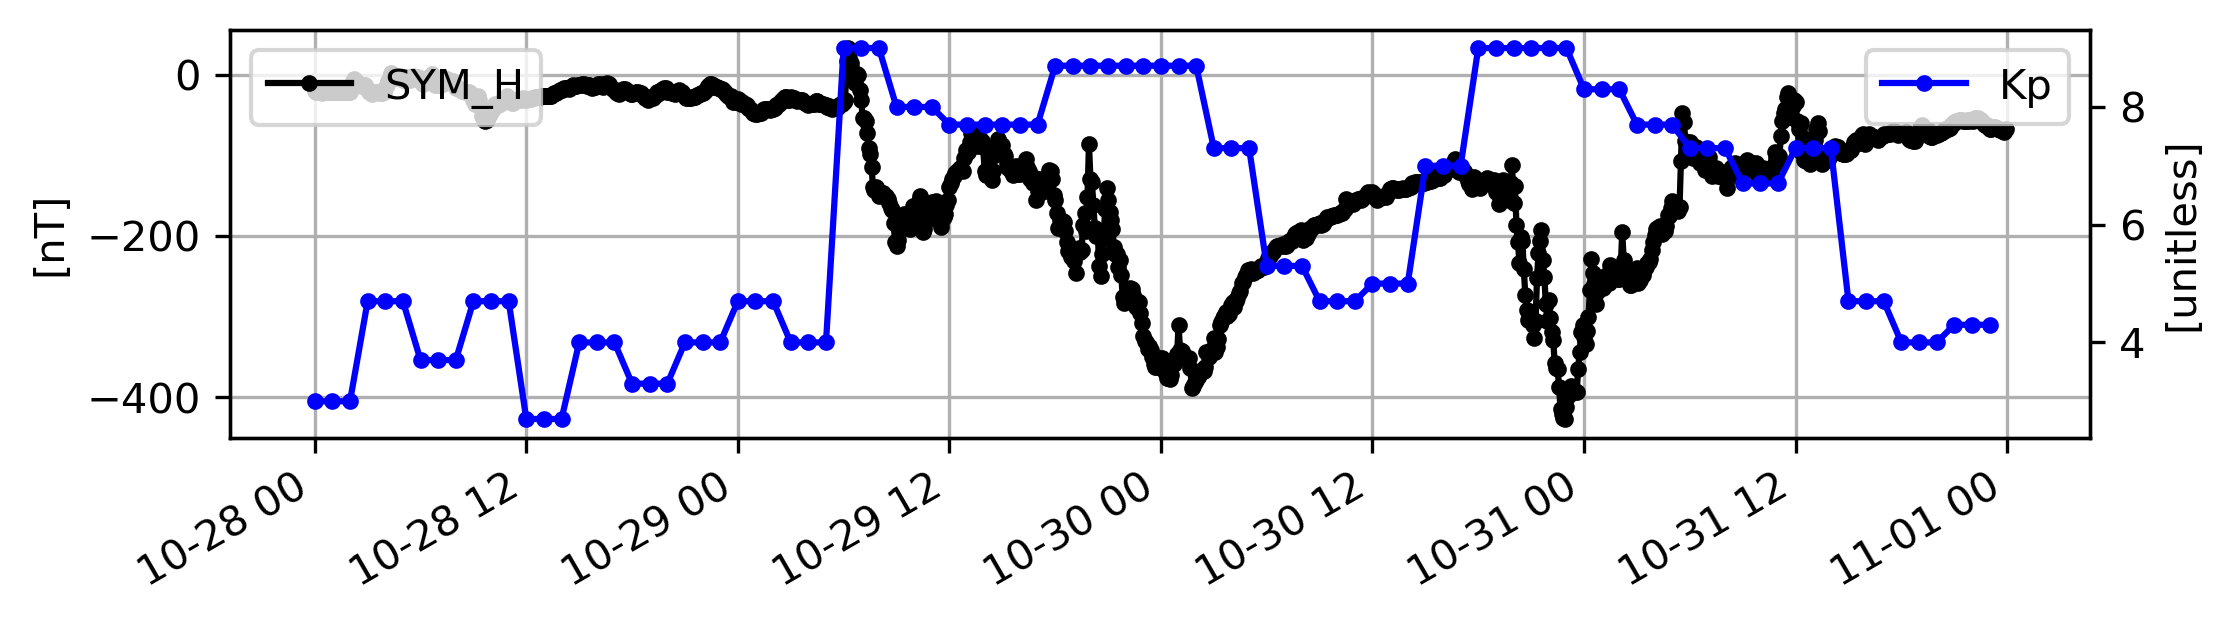

In [16]:
from ssjlatbin.fluxcalculations import average_particle_energy
from scipy.ndimage import median_filter
import matplotlib as mpl

lbdf = bin_by_latitude(df0,config,latvar='mlats')
t,lats,dusk_dawn,influxs = dataframe_to_latbinned_flux(lbdf,'ion_soft_number')
t,lats,_,enfluxh = dataframe_to_latbinned_flux(lbdf,'ele_hard_number')
t,lats,_,eeflux = dataframe_to_latbinned_flux(lbdf,'ele_total_energy')
t,lats,_,enflux = dataframe_to_latbinned_flux(lbdf,'ele_total_number')

#Calcuate the average electron energy, 
eavg = average_particle_energy(eeflux,enflux)
eavg[enflux==0]=0 #Prevent NaN values if zero number flux
eavg[eeflux<.01]=0

north_dawn_mask = np.logical_and(dusk_dawn==-1,lats>0)

f = plt.figure(figsize=(10,8),dpi=300,facecolor='white')

ax1 = f.add_subplot(411)
mappable1 = ax1.pcolormesh(t,lats[north_dawn_mask],median_filter(enfluxh,size=ksize)[:,north_dawn_mask].T,
                           vmin=1e8,vmax=1e13,norm=LogNorm(),zorder=1,alpha=.9)
#mappable2 = ax1.pcolormesh(t,lats[north_dawn_mask],median_filter(influxs,size=ksize)[:,north_dawn_mask].T,vmin=1e8,vmax=1e12,norm=LogNorm(),cmap='Reds')
ax1.set_ylabel('Magnetic Latitude')
f.colorbar(mappable1,label='Hard Electron Flux'+'\n'+r'$[\frac{\#}{m^2 s}]$',ax=ax1)
ax1.set_ylim([20,90])

ax2 = f.add_subplot(412)
mappable2 = ax2.pcolormesh(t,lats[north_dawn_mask],median_filter(influxs,size=ksize)[:,north_dawn_mask].T,
                           vmin=1e8,vmax=1e12,norm=LogNorm(),cmap='Reds',zorder=1,alpha=.9)
ax2.set_ylabel('Magnetic Latitude')
f.colorbar(mappable2,label='Soft Ion Flux'+'\n'+r'$[\frac{\#}{m^2 s}]$',ax=ax2)
ax2.set_ylim([20,90])

eavg = average_particle_energy(eeflux,enflux)
eavg[enflux==0]=0 #Prevent NaN values if zero number flux
eavg[eeflux<.1]=0

ax3 = f.add_subplot(413)
mappable31 = ax3.pcolormesh(t,lats[north_dawn_mask],median_filter(influxs,size=ksize)[:,north_dawn_mask].T,
                           vmin=1e8,vmax=1e12,norm=LogNorm(),cmap='Reds',zorder=1,alpha=.9)
mappable32 = ax3.pcolormesh(t,lats[north_dawn_mask],median_filter(enfluxh,size=ksize)[:,north_dawn_mask].T,
                           vmin=1e8,vmax=1e12,norm=LogNorm(),cmap='viridis',zorder=1,alpha=.9)
ax3.set_ylim([20,90])
ax3.set_ylabel('Magnetic Latitude')

f.colorbar(mpl.cm.ScalarMappable(norm=LogNorm(vmin=1e8,vmax=1e12),
                                 cmap='Greys_r'),ax=ax3, label='Particle Flux'+'\n'+r'$[\frac{\#}{m^2 s}]$')
ax4 = f.add_subplot(414)
mappable4 = ax4.pcolormesh(t,lats[north_dawn_mask],median_filter(eavg,size=ksize)[:,north_dawn_mask].T,
                           vmin=100,vmax=10000,norm=LogNorm(),cmap='plasma',zorder=1,alpha=.9)
ax4.set_ylim([20,90])
ax4.set_ylabel('Magnetic Latitude')
f.colorbar(mappable4,label='Electron Average \n Energy [eV]',ax=ax4)

ax1.xaxis.set_ticklabels('')
ax2.xaxis.set_ticklabels('')
ax3.xaxis.set_ticklabels('')
ax1.grid(True)
ax2.grid(True)
ax3.grid(True)
ax4.grid(True)

f.autofmt_xdate()
ax1.set_title('Northern Hemisphere Dawnside Particle Flux')
f.savefig(f'nh_dawn_{sdtstr}_{edtstr}.png')

from nasaomnireader.omnireader import omni_interval
oi = omni_interval(sdt,edt,'5min')
oih = omni_interval(sdt,edt,'hourly')

odt = oi['Epoch']
dst = oi['SYM_H']
ohdt = oih['Epoch']
kp = oih['KP']
f7 = plt.figure(figsize=(8,2),dpi=300,facecolor='white')
ax7 = f7.add_subplot(111)
ax7.grid(True)
ax7r = ax7.twinx()
ax7.plot(odt,dst,'k.-',label='SYM_H')
ax7r.plot(ohdt,kp,'b.-',label='Kp')
ax7r.set_ylabel('[unitless]')
ax7.legend(loc='upper left')
ax7r.legend(loc='upper right')
ax7.set_ylabel('[nT]')
f7.autofmt_xdate()
f7.savefig(f'nh_dawn_dst_kp_{sdtstr}_{edtstr}.png')